# Fully connected neural networks

<u>On kooplex tensorflow 2 does not work, please work on Google Colab and then upload your solution to kooplex! Also, on Google Colab you can use GPUs</u>

This week we will use the MNIST handwritten digits dataset! The weights.npy file is provided, which contains the weight vector for a traines fully connected neural network.

In [1]:
import os
import sklearn
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import display

In [2]:
from tqdm import tqdm
from tqdm import trange

from numba import jit
from numba import int32, float64
from numba.experimental import jitclass

In [3]:
import tensorflow as tf

In [4]:
print(tf.__version__)

2.2.0


In [5]:
data = './data/'
out = './out/'

# Bold print for Jupyter Notebook
b1 = '\033[1m'
b0 = '\033[0m'

### Just some matplotlib and seaborn parameter tuning

In [6]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## 1 - 2. Implement fully connected neural network via using only numpy

In this task we need to implement a small fully connected neural network that can generate predictions for us if we provide the weights and the input data!

 - implement the following function:
 ```python
 def pred_nn(weights, x_test):
    ...
    return predictions
 ```
 - x_test has a shape of (N_samples, 784)
 - predictions has a shape of (N_samples, 10)
 - then function implements a fully connected neural network with the follwing layers:
    - 750 neuron, relu activation
    - 500 neuron, relu activation
    - 500 neuron, relu activation
    - 10 neuron, softmax activation
 - weights is a numpy array of the weights
    - 1st element is a shape of (784, 750), 2nd is (750,), the bias
    - 3rd element is a shape of (750, 500), 4th is (500,)
    ... the rest matches the weight dimensions of the above-mentioned architecture
 - use numpy's built-in vectorized operations, try not to write for loops!
    
An optimally implemented function runs < 1s for N_samples = 10.000 

## 1./a. Implement an FC neural network from scratch using NumPy for fun

A very nice tutorial can be found [here](https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65), which summarizes every component of an FC neural network and gives a possible implementation of an FC neural network. This neural net in its core is based on that article.

### Disclaimer

This FC NN is made to learn both binary or multiclass datasets. Its structure copies mostly how the `Sequential()` networks work in `TF/keras`, so FC and activation layers can be attached to the network at ease and at will.

**However.**

For multiclass data like MNIST, a "meaningful" or "competent" loss function should be chosen, eg. categorical cross-entropy or something similar. I had just a day for this notebook, so I couldn't finish the implementation of an appropriate loss function. This network is therefore useless for training in its current form, but it can still give predictions using pre-defined weights and biases.

### 1. Create a template layer for FC and activation layers

In [7]:
class layer():
    def __init__(self):
        self.X = None
        self.Z = None

    # Computes the output Z of a layer for a given input X, W and B
    def forward_propagation(self, X):
        raise NotImplementedError

    # Computes dE/dX for a given dE/dZ (and update parameters if any)
    def backward_propagation(self, Z_error, learning_rate):
        raise NotImplementedError

### 2. Define the activation layer with different options for activations

In [8]:
# TANH
@jit(nopython=True)
def _tanh(X):
    return np.tanh(X)
@jit(nopython=True)
def _tanh_prime(X):
    return 1 - _tanh(X)**2

# RELU
@jit(nopython=True)
def _relu(X):
    return X * (X > 0)
@jit(nopython=True)
def _relu_prime(X):
    return np.ones_like(X) * (X > 0)

# SIGMOID
@jit(nopython=True)
def _sigm(X):
    return 1 / (1 + np.exp(-X))
@jit(nopython=True)
def _sigm_prime(X):
    return self.sigm(X) * (1 - self.sigm(X))

# SOFTMAX
@jit(nopython=True)
def _soft(X):
    shiftx = X - np.max(X)
    return np.exp(shiftx) / np.sum(np.exp(shiftx))
@jit(nopython=True)
def _soft_prime(X):
    """
    Parameters
    ----------
    X : numpy.ndarray of shape (input_size, output_size)

    Returns
    -------
    X_error : numpy.ndarray (input_size, output_size)

    Notes
    -----
    Nice tutorials at:
        `https://themaverickmeerkat.com/2019-10-23-Softmax/`
        `https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/`
        `https://aerinykim.medium.com/how-to-implement-the-softmax-derivative-independently-from-any-loss-function-ae6d44363a9d`

    """
    return _soft(X) * (1 - _soft(X))

In [9]:
_ACTIVATIONS = ['tanh', 'relu', 'sigm', 'soft']

In [10]:
class activations():
    """
    Defines activation functions and their derivatives.
    
    Parameters
    ----------
    a : str
        Chooses the activation method. Possible choices:
        - 'tanh' : Hyperbolic tangent
        - 'relu' : ReLU
        - 'sigm' : Sigmoid
        - 'soft' : Softmax
    """
    def __init__(self, a):
        assert a.lower() in _ACTIVATIONS,\
            "Possible activations are {0}!".format(_ACTIVATIONS)
        if a.lower() == 'tanh' : self.a = [_tanh,
                                             _tanh_prime]
        elif a.lower() == 'relu' : self.a = [_relu,
                                               _relu_prime]
        elif a.lower() == 'sigm' : self.a = [_sigm,
                                               _sigm_prime]
        elif a.lower() == 'soft' : self.a = [_soft,
                                               _soft_prime]

In [11]:
class activation_layer(layer):
    """
    Implements an activation step.
    
    Parameters
    ----------
    a : str
        Chooses the activation method. Possible choices:
        - 'tanh' : Hyperbolic tangent
        - 'relu' : ReLU
        - 'sigm' : Sigmoid
    """
    def __init__(self, a='relu'):
        self.a = a
        activation = activations(a)
        self.activation = activation.a[0]
        self.activation_prime = activation.a[1]

    # Returns the activated input
    def forward_propagation(self, X, **kwargs):
        self.X = X
        self.Z = self.activation(self.X)
        return self.Z

    # Returns X_error dE/dX for a given Z_error dE/dZ.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, Z_error, learning_rate):
        """
        
        Parameters
        ----------
        Z_error : numpy.ndarray of shape (output_size, )
        
        Returns
        -------
        X_error : numpy.ndarray of shape (output_size, input_size)
        """
        return Z_error * self.activation_prime(self.X)

### 3. Implement a scoring class

In [12]:
@jit(nopython=True)
def _catcross(y_true, y_pred):
    """
    Parameters
    ----------
    y_true : numpy.ndarray of shape (n_samples, )
        Groundtruth labels.
    y_pred : numpy.ndarray of shape (n_samples, )
        Predicted labels.
    """
    return -np.sum(y_true * np.log(_soft(y_pred)+1e-09))

@jit(nopython=True)
def _catcross_prime(y_true, y_pred):
    """
    Parameters
    ----------
    y_true : numpy.ndarray of shape (n_samples, )
        Groundtruth labels.
    y_pred : numpy.ndarray of shape (n_samples, )
        Predicted labels.
    """
    return y_pred - y_true

In [13]:
_LOSSES = ['catcross']

In [14]:
class Loss():
    """
    Defines loss functions and their derivatives.
    
    Parameters
    ----------
    a : str
        Chooses the loss function. Possible choices:
        - 'mse' : Mean Squared Error
    """
    def __init__(self, s='mse'):
        assert s.lower() in _LOSSES,\
            "Possible loss scores are {0}!".format(_LOSSES)
        if s.lower() == 'catcross' : self.l = [_catcross,
                                               _catcross_prime]

### 4. Implement a template for a general FC layer

In [15]:
class fc_layer():
    """
    Implements an FC layer.
    
    Parameters
    ----------
    input_size : int
        The number of input neurons.
    output_size : int
        The number of output neurons.
    """
    def __init__(self, input_size, output_size):
        """
        Initializes random weights at the start for the FC layer.
        
        W : numpy.ndarray of shape (input_size, output_size)
            Weights of the layer
        B : numpy.ndarray of shape (output_size, )
            Biases of the layer
        """
        self.input_size = input_size
        self.output_size = output_size
        self.W = np.random.rand(self.input_size, self.output_size) - 0.5
        self.B = np.random.rand(1, self.output_size) - 0.5

    def forward_propagation(self, X, **kwargs):
        """
        Implements the forward propagation step for the current
        FC layer. Returns output for a given input.
        
        Parameters
        ----------
        X : numpy.ndarray of shape (input_size, output_size)
            Input data of the forward propagataion of the FC layer.
        
        Returns
        -------
        Z : numpy.ndarray of shape(output_size, )
            Output of the forward propagation of the FC layer.
        """
        if 'w' in kwargs : self.W = kwargs['w']
        if 'b' in kwargs : self.B = kwargs['b']
        self.X = X.reshape(1, -1) if X.ndim == 1 else X
        self.Z = np.dot(self.X, self.W) + self.B
        return self.Z

    def backward_propagation(self, Z_error, learning_rate):
        """
        Implements the backward propagation step for the current
        FC layer. Computes dE/dW, dE/dB for a given output_error
        dE/dZ. Returns input_error dE/dX.
        
        Parameters
        ----------
        Z_error : numpy.ndarray of shape (output_size, )
            Output error of the FC layer.
        learning_rate : float
            Learning rate for the parameter convergence.
            
        Returns
        -------
        X_error : numpy.ndarray of shape (output_size, input_size)
            Input error of the FC layer.
        """
        X_error = np.dot(Z_error, self.W.T)
        W_error = np.dot(self.X.T, Z_error)
        
        # Update parameters
        self.W -= learning_rate * W_error
        self.B -= learning_rate * Z_error
        return X_error

### 5. Create network class to build arbitrary networks with

In [16]:
class fc_nn():
    """
    Implements an FC neural network.
    """
    def __init__(self, s='mse'):
        # Layers
        self.layers = []
        self._fitted = False

    # Add layer to network
    def add(self, layer):
        self.layers.append(layer)
        
    def config(self, s='catcross'):
        # Loss function
        self.s = s
        loss = Loss(s)
        self.loss = loss.l[0]
        self.loss_prime = loss.l[1]

    def predict(self, X, **kwargs):
        """
        Make predictions using the weights and biases of
        a fitted model. This function is the task to do in this
        assignment.
        
        Parameters
        ----------
        X : numpy.ndarray of shape (input_size, output_size)
        """
        result = []
        for Z in X:
            # Forward propagation
            for i, layer in enumerate(self.layers):
                params = {}
                if 'W' in kwargs : params['w'] = kwargs['W'][i//2]
                if 'B' in kwargs : params['b'] = kwargs['B'][i//2]
                Z = layer.forward_propagation(X=Z, **params)
            result.append(Z)
        return np.array(result)

    # Train the network
    def fit(self, X_train, y_train, epochs, learning_rate=0.01):
        self.epochs = epochs
        self.learning_rate = learning_rate
        for i in range(epochs):
            # Number of train data
            n_samples = len(X_train)            
            
            # I'm training without batches here
            pbar = tqdm(range(n_samples))   # 
            err = 0                         # Log accuracy
            for j in pbar:
                Z = X_train[j]
                y_true = y_train[j]
                # I. Forward propagation
                for layer in self.layers:
                    Z = layer.forward_propagation(Z)

                # Compute loss
                err += self.loss(y_true, Z)
                
                # II. Backward propagation
                Z_error = self.loss_prime(y_true, Z)
                for layer in reversed(self.layers):
                    Z_error = layer.backward_propagation(Z_error, learning_rate)

                # calculate average error on all samples
                pbar.set_description('Epoch {0}/{1}  loss : {2:.3f}'.format(i+1, epochs, err/n_samples))
        # Fitting finished
        self._fitted = True

## Load in data and predict the network with the given weights

In [17]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [18]:
# Make classification
X, y = make_classification(n_samples=10000, n_features=784, n_informative=40, n_classes=10)
# Create one-hot encoded y dataset
b = np.zeros((y.size, y.max()+1))
b[np.arange(y.size),y] = 1
y = b
# Create Train/Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
# Create the network
model = fc_nn()
model.add(fc_layer(784, 750))
model.add(activation_layer(a='relu'))
model.add(fc_layer(750, 500))
model.add(activation_layer(a='relu'))
model.add(fc_layer(500, 500))
model.add(activation_layer(a='relu'))
model.add(fc_layer(500, 10))
model.add(activation_layer(a='soft'))

model.config(s='catcross')

In [20]:
model.fit(X_train, y_train, epochs=5, learning_rate=0.01)

Epoch 5/5  loss : 2.358: 100%|██████████| 8000/8000 [01:48<00:00, 73.84it/s]


### Analyze predictions

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

In [22]:
def onehot_2_normal(X):
    """
    Convert one-hot encoded matrix to 1D array of label indeces.
    """
    return np.array([np.where(p == 1)[0][0]+1 for p in X])

In [23]:
def accuracy_metric(y_test, y_pred):
    """
    Calculate accuracy of model prediction.
    
    Parameters
    ----------
    y_test : array-like of shape (N, )
        Original labels of the test dataset.
    
    y_pred : array-like of shape (N, )
        Predicted labels of the test dataset.
    
    Returns
    -------
    Accuracy of model in reference of the true test labels.
    """
    # Binarize labels
    y_test = label_binarize(y_test, classes=np.unique(y_test))
    y_pred = label_binarize(y_pred, classes=np.unique(y_pred))

    correct = 0
    for (t, p) in zip(y_test, y_pred):
        if t.tolist() == p.tolist():
            correct += 1
    return correct / len(y_test) * 100

In [24]:
def plot_confusion_matrix(conf_mat, y, labels=None, title=None):
    """
    Plots a confusion matrix.
    """
    fig, axes = plt.subplots(figsize=(14,14))
    axes.set_aspect('equal')

    im = axes.imshow(conf_mat)
    # Loop over data dimensions and create text annotations.
    for X in range(conf_mat.shape[0]):
        for Y in range(conf_mat.shape[1]):
            axes.text(Y, X, conf_mat[X, Y], fontsize=30,
                      ha='center', va='center', color='white', fontweight='bold', 
                      bbox=dict(color=np.array((0,0,0,0.2)), lw=0)
                     )

    # Set axis tick locations and labels
    ticks = [i for i in range(len(set(y)))]
    if labels is None:
        ticklabels = [i+1 for i in range(len(set(y)))]
    else:
        ticklabels = list(labels)

    axes.set_xticks(ticks)
    axes.set_xticklabels(ticklabels)
    axes.set_yticks(ticks)
    axes.set_yticklabels(ticklabels)

    axes.set_xlabel('Predicted labels', fontsize=axislabelsize+5, fontweight='bold')
    axes.set_ylabel('True labels', fontsize=axislabelsize+5, fontweight='bold')
    axes.tick_params(axis='both', which='major', labelsize=axisticksize+5)
    axes.xaxis.tick_top()
    axes.xaxis.set_label_position('top') 

    axes.grid(False)

    # Create an axis on the right side of `axes`. The width of `cax` will be 5%
    # of `axes` and the padding between `cax` and axes will be fixed at 0.1 inch
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(mappable=im, cax=cax)
    cbar.ax.tick_params(labelsize=axiscbarfontsize, colors='black')
    cbar.set_label('Number of occurences', fontsize=axiscbarfontsize+10, labelpad=15, rotation=90)

    plt.suptitle(title,
                 fontsize=axistitlesize+5, y=0.1)

    plt.show()

In [25]:
y_pred = model.predict(X_test).reshape(y_test.shape)
for i in range(len(y_test)):
    l = y_pred[i]
    y_pred[i] = (l == np.max(l)) * np.ones_like(l)

In [26]:
# Convert one-hot encoded preds and tests to normal arrays
y_test_n = onehot_2_normal(y_test)
y_pred_n = onehot_2_normal(y_pred)

# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test_n, y_pred=y_pred_n)
conf_mat = confusion_matrix(y_test_n, y_pred_n, labels=[i for i in range(1,11)])

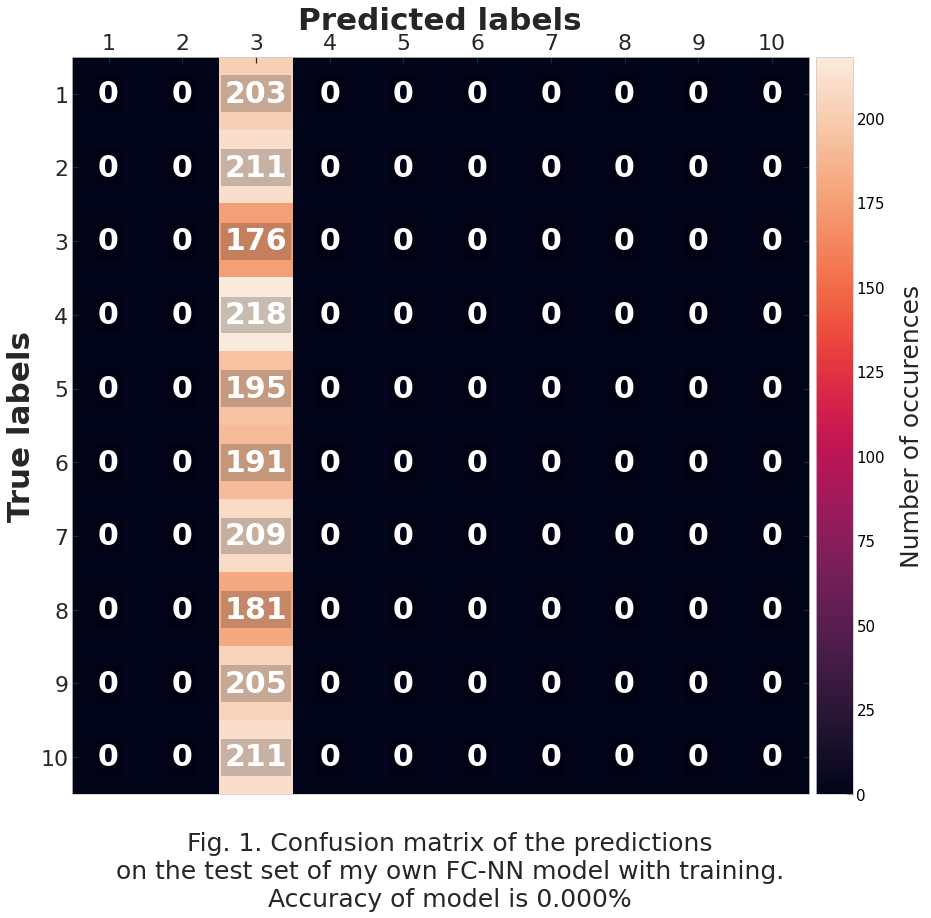

In [27]:
plot_confusion_matrix(conf_mat, y_test_n, labels=[i for i in range(1,11)],
                      title=('Fig. 1. Confusion matrix of the predictions\n' +
                             'on the test set of my own FC-NN model with training.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

### Load weights to model during predictions (actual task)

Obviously these weights and biases has no relation to my randomly generated dataset.

In [28]:
W = np.load(data + 'weights.npy', allow_pickle=True)
for i in range(W.shape[0]):
    print('Layer {0} shape: {1}'.format(i+1, W[i].shape))

Layer 1 shape: (784, 750)
Layer 2 shape: (750,)
Layer 3 shape: (750, 500)
Layer 4 shape: (500,)
Layer 5 shape: (500, 500)
Layer 6 shape: (500,)
Layer 7 shape: (500, 10)
Layer 8 shape: (10,)


In [29]:
y_pred = model.predict(X_test, W=W[::2], B=W[1::2]).reshape(y_test.shape)
for i in range(len(y_test)):
    l = y_pred[i]
    y_pred[i] = (l == np.max(l)) * np.ones_like(l)

In [30]:
# Convert one-hot encoded preds and tests to normal arrays
y_test_n = onehot_2_normal(y_test)
y_pred_n = onehot_2_normal(y_pred)

# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test_n, y_pred=y_pred_n)
conf_mat = confusion_matrix(y_test_n, y_pred_n, labels=[i for i in range(1,11)])

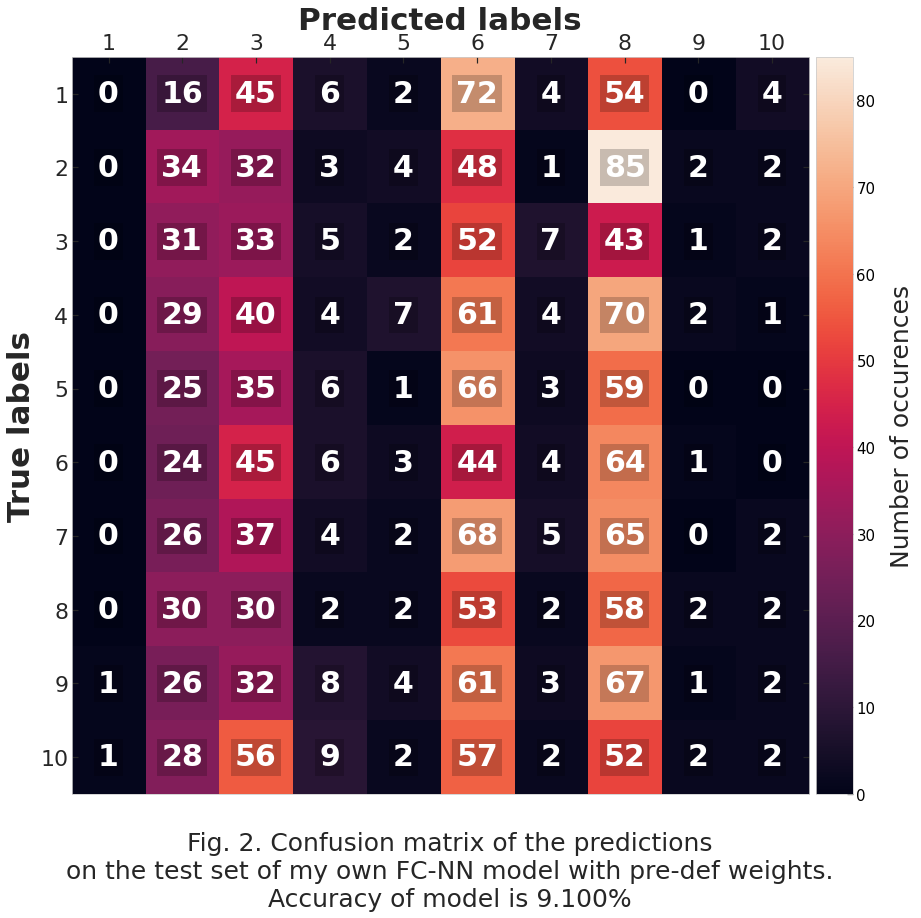

In [31]:
plot_confusion_matrix(conf_mat, y_test_n, labels=[i for i in range(1,11)],
                      title=('Fig. 2. Confusion matrix of the predictions\n' +
                             'on the test set of my own FC-NN model with pre-def weights.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

## 3.  Same architecture via tensorflow/keras

 - Implement the same architecture with tensorflow/keras as we did in 1-2). 
 - Load the provided weights for the neural network!

In [56]:
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

In [57]:
# Build the network
model = Sequential()
# FC + activation layers
model.add(Dense(750, input_dim=784, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [58]:
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [59]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3625 - accuracy: 0.9064
Epoch 2/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.2132 - accuracy: 0.9459
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1917 - accuracy: 0.9536
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1771 - accuracy: 0.9571
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1705 - accuracy: 0.9605
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1365 - accuracy: 0.9673
Epoch 7/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1411 - accuracy: 0.9666
Epoch 8/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1443 - accuracy: 0.9658
Epoch 9/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1504 - accuracy: 0.9661
Epoch 10/10
1875/1875 [==============================] - 17s 9ms/step - l

In [60]:
y_pred = model.predict(X_test)
for i in range(len(y_test)):
    l = y_pred[i]
    y_pred[i] = (l == np.max(l)) * np.ones_like(l)

In [61]:
# Convert one-hot encoded preds and tests to normal arrays
y_test_n = onehot_2_normal(y_test)
y_pred_n = onehot_2_normal(y_pred)

# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test_n, y_pred=y_pred_n)
conf_mat = confusion_matrix(y_test_n, y_pred_n, labels=[i for i in range(1,11)])

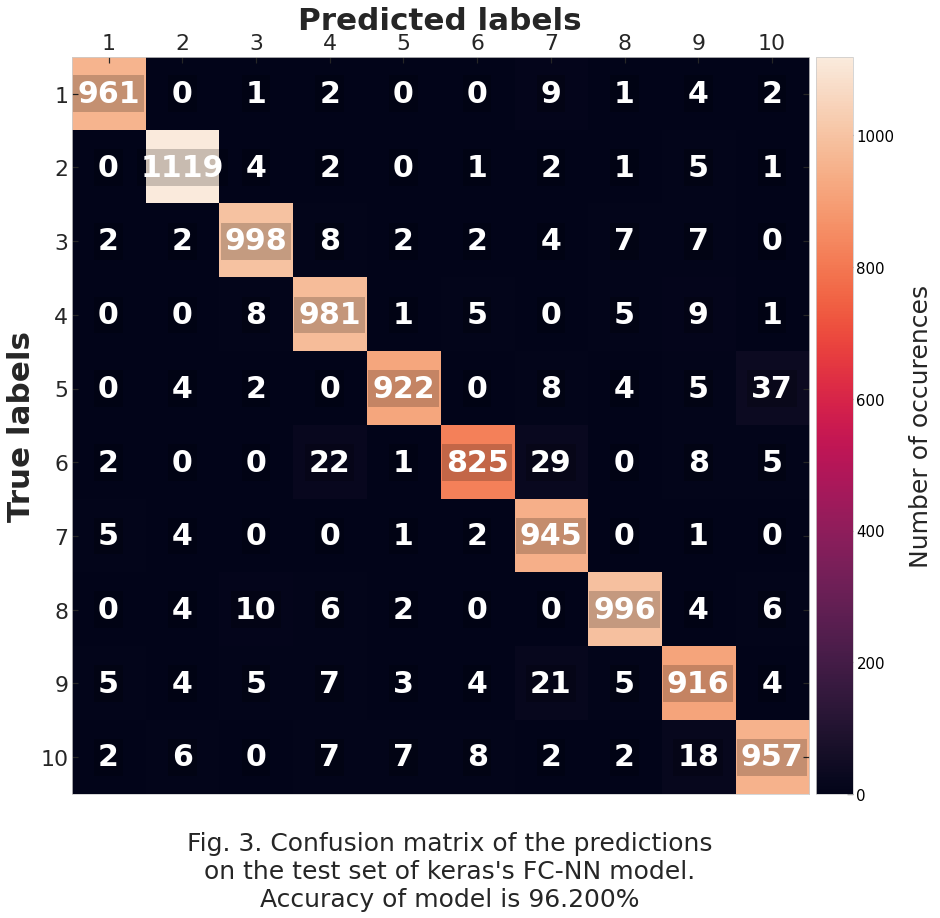

In [62]:
plot_confusion_matrix(conf_mat, y_test_n, labels=[i for i in range(1,11)],
                      title=('Fig. 3. Confusion matrix of the predictions\n' +
                             'on the test set of keras\'s FC-NN model.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

## 4-5. Compate performances
 - load the MNIST dataset from the tensorflow/keras built-in dataset
 - use the original train/test split!
 - divide each pixel's value by 255 & reshape to have 1D input vector (784) instead of the 2D matrix (28x28)
   - eg for the test set you will have a (10000, 784) shaped vector
 - generate prediction for the 10.000 test images with both methods!
 - calculate the categorical cross-entropy loss and the accuracy for both methods! are they the same? (if not, it indicates a bug somewhere...) Hint: you should get ~97% accuracy
 - show the confusion matrix of the predictions (predicted values vs actual labels)
 - where does the model make mistakes?

### Preprocess MNIST dataset

In [39]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
# Scale and reshape data
X_train = X_train.reshape(60000, 784) / 255
X_test = X_test.reshape(10000, 784) / 255
y_train = label_binarize(y_train, classes=np.unique(y_train))
y_test = label_binarize(y_test, classes=np.unique(y_test))

In [40]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


### I./a. Train MNIST with TF/Keras

In [41]:
# Build the network
model = Sequential()
# FC + activation layers
model.add(Dense(750, input_dim=784, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [42]:
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [43]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3713 - accuracy: 0.9042
Epoch 2/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.2421 - accuracy: 0.9400
Epoch 3/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2152 - accuracy: 0.9475
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1774 - accuracy: 0.9568
Epoch 5/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1812 - accuracy: 0.9581
Epoch 6/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1508 - accuracy: 0.9627
Epoch 7/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1562 - accuracy: 0.9633
Epoch 8/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1452 - accuracy: 0.9656
Epoch 9/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1367 - accuracy: 0.9685
Epoch 10/10
1875/1875 [==============================] - 12s 7ms/step - l

In [44]:
y_pred = model.predict(X_test)
for i in range(len(y_test)):
    l = y_pred[i]
    y_pred[i] = (l == np.max(l)) * np.ones_like(l)

In [45]:
# Convert one-hot encoded preds and tests to normal arrays
y_test_n = onehot_2_normal(y_test)
y_pred_n = onehot_2_normal(y_pred)

# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test_n, y_pred=y_pred_n)
conf_mat = confusion_matrix(y_test_n, y_pred_n, labels=[i for i in range(1,11)])

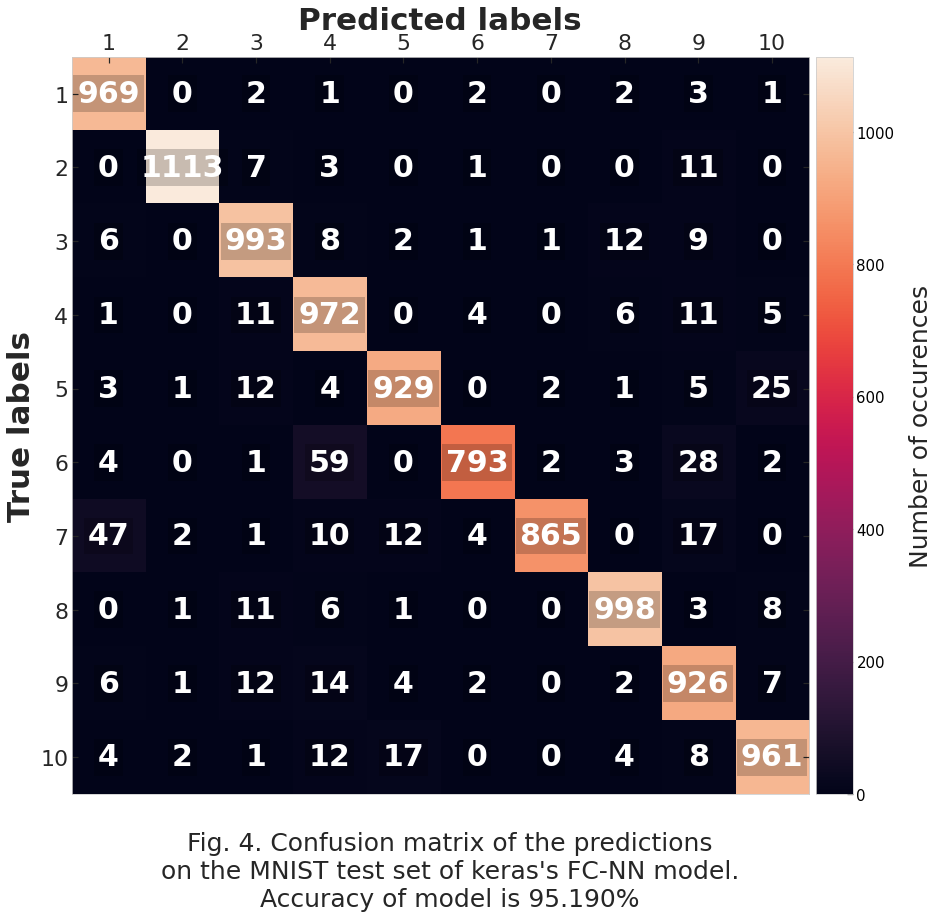

In [46]:
plot_confusion_matrix(conf_mat, y_test_n, labels=[i for i in range(1,11)],
                      title=('Fig. 4. Confusion matrix of the predictions\n' +
                             'on the MNIST test set of keras\'s FC-NN model.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

### I./b. Load weights for MNIST with TF/Keras

In [47]:
model.set_weights(W)

In [48]:
y_pred = model.predict(X_test)
for i in range(len(y_test)):
    l = y_pred[i]
    y_pred[i] = (l == np.max(l)) * np.ones_like(l)

In [49]:
# Convert one-hot encoded preds and tests to normal arrays
y_test_n = onehot_2_normal(y_test)
y_pred_n = onehot_2_normal(y_pred)

# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test_n, y_pred=y_pred_n)
conf_mat = confusion_matrix(y_test_n, y_pred_n, labels=[i for i in range(1,11)])

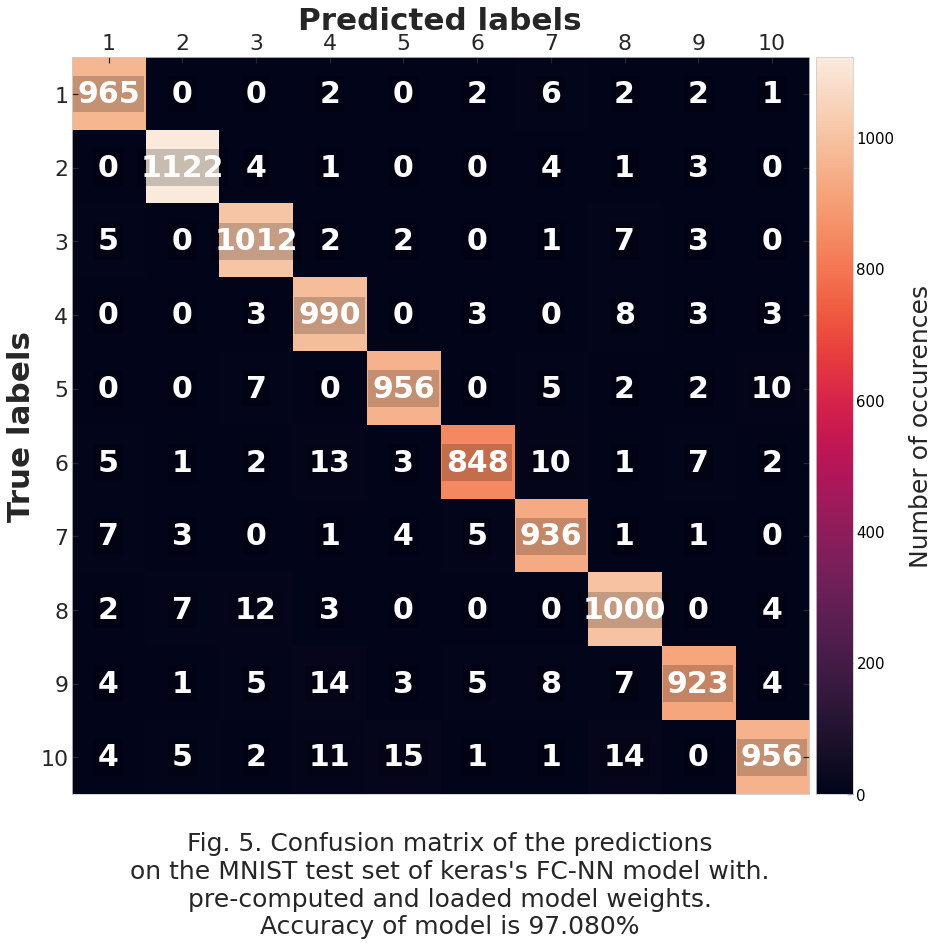

In [50]:
plot_confusion_matrix(conf_mat, y_test_n, labels=[i for i in range(1,11)],
                      title=('Fig. 5. Confusion matrix of the predictions\n' +
                             'on the MNIST test set of keras\'s FC-NN model with.\n' +
                             'pre-computed and loaded model weights.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

### II. MNIST with own FC-NN

In [51]:
# Create the network
model = fc_nn()
model.add(fc_layer(784, 750))
model.add(activation_layer(a='relu'))
model.add(fc_layer(750, 500))
model.add(activation_layer(a='relu'))
model.add(fc_layer(500, 500))
model.add(activation_layer(a='relu'))
model.add(fc_layer(500, 10))
model.add(activation_layer(a='soft'))

model.config(s='catcross')

In [52]:
W = np.load(data + 'weights.npy', allow_pickle=True)
for i in range(W.shape[0]):
    print('Layer {0} shape: {1}'.format(i+1, W[i].shape))

Layer 1 shape: (784, 750)
Layer 2 shape: (750,)
Layer 3 shape: (750, 500)
Layer 4 shape: (500,)
Layer 5 shape: (500, 500)
Layer 6 shape: (500,)
Layer 7 shape: (500, 10)
Layer 8 shape: (10,)


In [53]:
y_pred = model.predict(X_test, W=W[::2], B=W[1::2]).reshape(y_test.shape)
for i in range(len(y_test)):
    l = y_pred[i]
    y_pred[i] = (l == np.max(l)) * np.ones_like(l)

In [54]:
# Convert one-hot encoded preds and tests to normal arrays
y_test_n = onehot_2_normal(y_test)
y_pred_n = onehot_2_normal(y_pred)

# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test_n, y_pred=y_pred_n)
conf_mat = confusion_matrix(y_test_n, y_pred_n, labels=[i for i in range(1,11)])

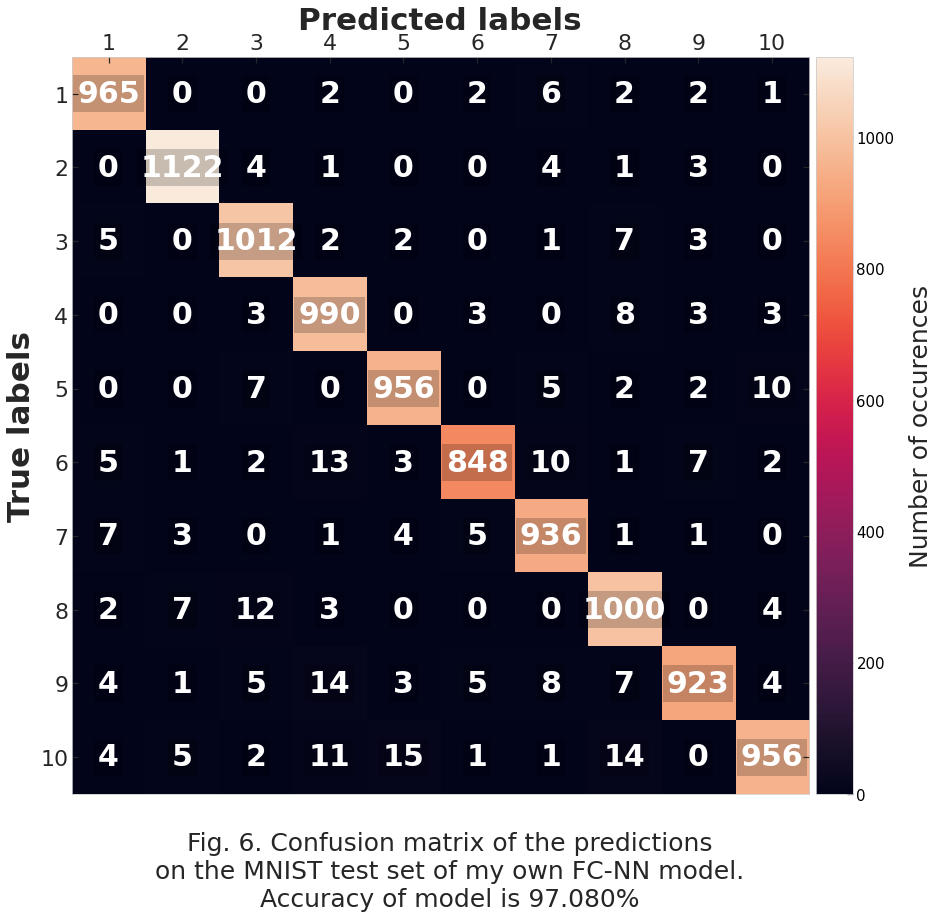

In [55]:
plot_confusion_matrix(conf_mat, y_test_n, labels=[i for i in range(1,11)],
                      title=('Fig. 6. Confusion matrix of the predictions\n' +
                             'on the MNIST test set of my own FC-NN model.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

### Conclusion

The accuracies are the same for both Keras and my own FC-NN model, which means the predictions are correct.

### Hints:
 - On total you can get 10 points for fully completing all tasks.
 - Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
 - Comments you code when necessary
 - Write functions for repetitive tasks!
 - Use the pandas package for data loading and handling
 - Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
 - Use the scikit learn package for almost everything
 - Use for loops only if it is really necessary!
 - Code sharing is not allowed between student! Sharing code will result in zero points.
 - If you use code found on web, it is OK, but, make its source clear! 